<a href="https://colab.research.google.com/github/mehedils/ColabCodeRandom/blob/main/Fit_unfit_bus.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!curl -L -o /content/bus-image-dataset.zip \
  https://www.kaggle.com/api/v1/datasets/download/mdtasnimulhassankhan/bus-image-dataset

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 1972M  100 1972M    0     0  87.1M      0  0:00:22  0:00:22 --:--:--  122M


In [2]:
!unzip -q /content/bus-image-dataset.zip

In [6]:
import pathlib
data_dir = pathlib.Path("./Dataset/Train Data")
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

2089


In [15]:
import tensorflow as tf
TRAIN_BASE_DIR = "./Dataset/Train Data"
TEST_BASE_DIR = "./Dataset/Test Data"
IMG_SIZE = 224
BATCH_SIZE = 32

In [17]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    TRAIN_BASE_DIR,
    shuffle=True,
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE
)
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    TEST_BASE_DIR,
    shuffle=True,
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE
)

Found 2270 files belonging to 2 classes.
Found 600 files belonging to 2 classes.


In [18]:
class_names = train_ds.class_names
class_names

['Fit Bus', 'Unfit Bus']

In [11]:
import matplotlib.pyplot as plt

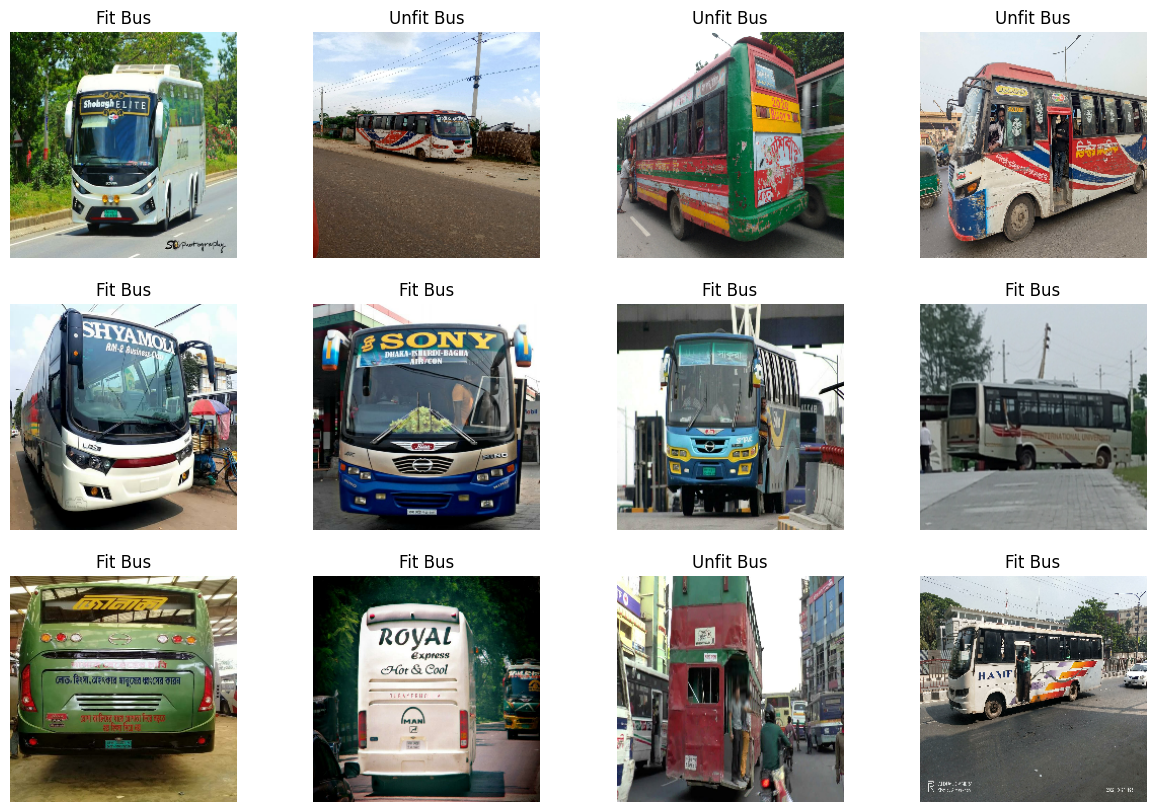

In [19]:
plt.figure(figsize=(15, 10))

for image_batch, label_batch in train_ds.take(1):
  for i in range(12):
    ax = plt.subplot(3, 4, i + 1)
    plt.imshow(image_batch[i].numpy().astype("uint8"))
    plt.title(class_names[label_batch[i]])
    plt.axis("off")

In [20]:
train_ds = train_ds.shuffle(1000).cache().prefetch(buffer_size=tf.data.AUTOTUNE)

In [21]:
test_ds = test_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

In [22]:
from tensorflow.keras import layers

resize_and_rescale = tf.keras.Sequential([
  layers.Resizing(IMG_SIZE, IMG_SIZE),
  layers.Rescaling(1./255)
])

data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.2)
])


In [25]:
CHANNELS = 3

base_model = tf.keras.applications.ResNet101(
    include_top=False,
    weights="imagenet",
    input_shape=(IMG_SIZE, IMG_SIZE, CHANNELS),
)

base_model.trainable = False

171446536/171446536 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [26]:
model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),  # or tf.keras.layers.Flatten()
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.5),  # Optional: helps prevent overfitting
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.3),  # Optional: helps prevent overfitting
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')  # Final output layer for 10 classes
])

In [27]:
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',  # this is for categorial(important to remeber)
    metrics=['accuracy']

)

In [28]:
epoches = 10
history = model.fit(
    train_ds,
    epochs=epoches,
    validation_data=test_ds,
    verbose=1
)

Epoch 1/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 111s 615ms/step - accuracy: 0.6532 - loss: 0.9555 - val_accuracy: 0.8950 - val_loss: 0.2993
Epoch 2/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 13s 186ms/step - accuracy: 0.8145 - loss: 0.3973 - val_accuracy: 0.9017 - val_loss: 0.2497
Epoch 3/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 14s 192ms/step - accuracy: 0.8540 - loss: 0.3373 - val_accuracy: 0.9017 - val_loss: 0.2448
Epoch 4/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 13s 190ms/step - accuracy: 0.8702 - loss: 0.3095 - val_accuracy: 0.9100 - val_loss: 0.2191
Epoch 5/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 13s 185ms/step - accuracy: 0.8684 - loss: 0.3035 - val_accuracy: 0.9133 - val_loss: 0.2097
Epoch 6/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 13s 183ms/step - accuracy: 0.8848 - loss: 0.2818 - val_accuracy: 0.9200 - val_loss: 0.2105
Epoch 7/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 13s 182ms/step - accuracy: 0.8839 - loss: 0.2644 - val_accuracy: 0.9217 - val_loss: 0.2072
Epoch 8/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 13s 183ms/step - accuracy: 0.8879 - loss: 0.2340 - val_acc

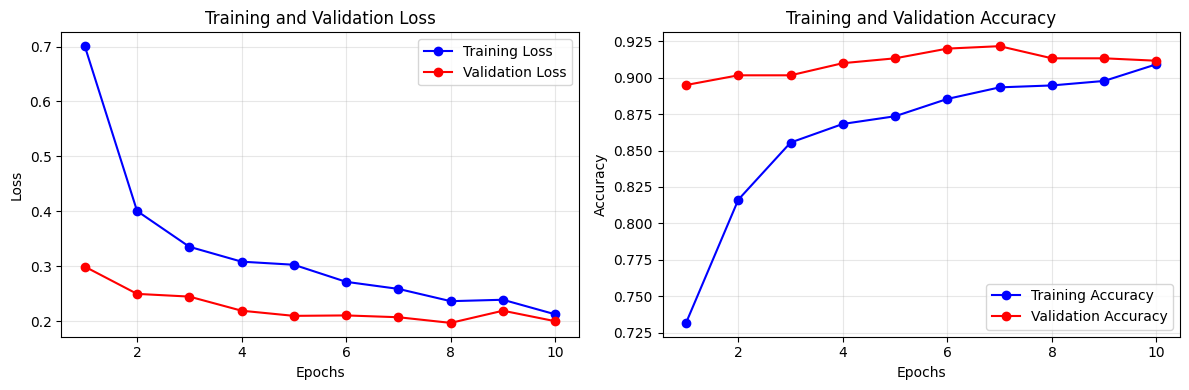

In [29]:
# Get metrics from history
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(1, len(train_loss) + 1)

# Create the plots
plt.figure(figsize=(12, 4))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, 'b-o', label='Training Loss')
plt.plot(epochs, val_loss, 'r-o', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.3)

# Accuracy plot
plt.subplot(1, 2, 2)
plt.plot(epochs, train_acc, 'b-o', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r-o', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [30]:
test_results = model.evaluate(test_ds, verbose=1)

print(f"Test Loss: {test_results[0]:.4f}")
print(f"Test Accuracy: {test_results[1]:.4f}")


19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 145ms/step - accuracy: 0.9139 - loss: 0.2120
Test Loss: 0.2000
Test Accuracy: 0.9117


19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 147ms/step


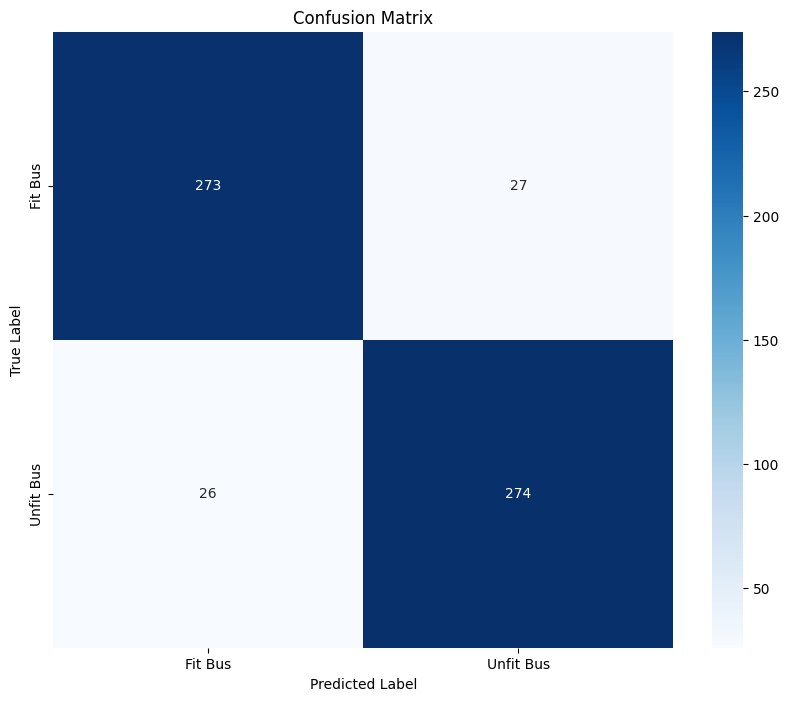

In [32]:
from sklearn.metrics import confusion_matrix
import numpy as np
import seaborn as sns

# Get true labels and predictions for the test dataset
test_labels = np.concatenate([y for x, y in test_ds], axis=0)
test_predictions = np.argmax(model.predict(test_ds), axis=1)

# Calculate the confusion matrix
cm = confusion_matrix(test_labels, test_predictions)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [33]:
from sklearn.metrics import classification_report

report = classification_report(test_labels, test_predictions, target_names=class_names)

print("Classification Report:\n", report)

Classification Report:
               precision    recall  f1-score   support

     Fit Bus       0.91      0.91      0.91       300
   Unfit Bus       0.91      0.91      0.91       300

    accuracy                           0.91       600
   macro avg       0.91      0.91      0.91       600
weighted avg       0.91      0.91      0.91       600

